# Avance 5. Modelo final
## Proyecto Integrador MNA - Alzheimer

### 1. Importación de librerías

In [100]:
# Núcleo y Manipulación de Datos
import pandas as pd
import numpy as np
import time
import itertools

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Modelos Individuales
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Modelos de Ensamble
import xgboost as xgb
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

# Evaluación y Métricas
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Ignorar advertencias para una salida limpia
import warnings
warnings.filterwarnings("ignore")

print("Librerías importadas exitosamente.")

Librerías importadas exitosamente.


### 2. Carga y Preparación de Datos

#### 2.1 Carga de Datos

In [101]:
# --- CARGA DE DATOS ---
# Se carga el archivo CSV procesado a nivel nacional.
path = r'../data/processed/data_processed_v3_NoAcum_Total.csv'
df_national = pd.read_csv(path)
df_national.head()

,Year,Week,Date,Entity,Epi_Year,total_cases
0,2014,2,2014-01-13,Aguascalientes,2014,0.0
1,2014,3,2014-01-20,Aguascalientes,2014,0.0
2,2014,4,2014-01-27,Aguascalientes,2014,0.0
3,2014,5,2014-02-03,Aguascalientes,2014,0.0
4,2014,6,2014-02-10,Aguascalientes,2014,0.0


#### 2.2 Preparación Para Prophet y SARIMAX

In [102]:
# --- PREPARACIÓN DE DATOS (TIPO 1: UNIVARIADO) ---
# Para Prophet y SARIMAX

# Se crea la base de datos (df_ts) con índice de tiempo y frecuencia semanal
df_ts = df_national.copy()
df_ts['Date'] = pd.to_datetime(df_ts['Date'])
df_ts = df_ts.groupby('Date', as_index=False)['total_cases'].sum()
df_ts = df_ts.set_index('Date')
df_ts = df_ts.asfreq('W-MON') # Se usa Lunes
df_ts['total_cases'] = df_ts['total_cases'].fillna(0) # Se rellenan huecos

print(f"Datos Univariados (df_ts) listos con {len(df_ts)} filas.")

df_ts.head()

Datos Univariados (df_ts) listos con 572 filas.


,total_cases
Date,
2014-01-13,4.0
2014-01-20,29.0
2014-01-27,47.0
2014-02-03,36.0
2014-02-10,42.0


#### 2.3 Preparación Para XGBoost y Stacking

In [103]:
# --- PREPARACIÓN DE DATOS (TIPO 2: CON CARACTERÍSTICAS) ---
# Para XGBoost y Stacking

df_fe = df_ts.copy()

# Se crean características (lags, ventanas móviles, fecha)
window = 4
df_fe['Lag_1'] = df_fe['total_cases'].shift(1)
df_fe['Lag_2'] = df_fe['total_cases'].shift(2)
df_fe['Lag_3'] = df_fe['total_cases'].shift(3)
df_fe['Lag_4'] = df_fe['total_cases'].shift(4)
df_fe['Media_Movil_4'] = df_fe['total_cases'].rolling(window=window).mean()
df_fe['Std_Movil_4'] = df_fe['total_cases'].rolling(window=window).std()
df_fe['Mes'] = df_fe.index.month
df_fe['Semana_del_Año'] = df_fe.index.isocalendar().week.astype(int)

# Se eliminan los NaNs generados por los lags y rolling windows
df_fe.dropna(inplace=True)

print(f"Datos con Características (df_fe) listos con {len(df_fe)} filas.")

df_fe.head()


Datos con Características (df_fe) listos con 568 filas.


,total_cases,Lag_1,Lag_2,Lag_3,Lag_4,Media_Movil_4,Std_Movil_4,Mes,Semana_del_Año
Date,,,,,,,,,
2014-02-10,42.0,36.0,47.0,29.0,4.0,38.50,7.767453,2,7
2014-02-17,30.0,42.0,36.0,47.0,29.0,38.75,7.365460,2,8
2014-02-24,45.0,30.0,42.0,36.0,47.0,38.25,6.652067,2,9
2014-03-03,34.0,45.0,30.0,42.0,36.0,37.75,6.946222,3,10
2014-03-10,28.0,34.0,45.0,30.0,42.0,34.25,7.588368,3,11


#### 2.4 División de conjuntos (TRAIN/TEST)

In [104]:
# --- DIVISIÓN DE DATOS (TRAIN/TEST) ---

# Se define el punto de corte (80/20)
split_idx = int(len(df_ts) * 0.8)

# --- Split para datos Univariados (Prophet, SARIMAX) ---
train_ts = df_ts[:split_idx].copy()
test_ts  = df_ts[split_idx:].copy()

# --- Split para datos con Características (XGBoost, Stacking) ---
# Se asegura que la división sea en el mismo punto exacto.
# Se busca la fecha de inicio del set de prueba univariado.
test_start_date = test_ts.index[0]

train_fe = df_fe[df_fe.index < test_start_date].copy()
test_fe  = df_fe[df_fe.index >= test_start_date].copy()

# Se definen los X (features) e y (target) para los modelos de ML
X_train = train_fe.drop('total_cases', axis=1)
y_train = train_fe['total_cases']
X_test = test_fe.drop('total_cases', axis=1)
y_test = test_fe['total_cases']

print("\nDivisión de datos completada.")
print(f"Registros de entrenamiento (train_fe): {len(train_fe)}")
print(f"Registros de prueba (test_fe):     {len(test_fe)}")


División de datos completada.
Registros de entrenamiento (train_fe): 453
Registros de prueba (test_fe):     115


### 3. Ensamble Homogéneo (XGBoost)

Se implementará un modelo XGBRegressor (Extreme Gradient Boosting). Esta es una técnica de ensamble homogéneo de tipo boosting, lo que significa que construye cientos de árboles de decisión de forma secuencial, donde cada nuevo árbol aprende de los errores del anterior.

Se aplicará GridSearchCV (Búsqueda en Rejilla) para encontrar la mejor combinación de hiperparámetros.

Dado que estamos trabajando con series de tiempo, no se puede usar la validación cruzada estándar (que mezcla los datos aleatoriamente). En su lugar, se utilizará TimeSeriesSplit, que asegura que los datos de validación siempre sean posteriores a los datos de entrenamiento, simulando un escenario de pronóstico real.

#### 3.1 Configuración de parámetros de GridSearch para el modelo XGBoost

In [105]:
# --- MODELO DE ENSAMBLE HOMOGÉNEO (XGBoost) ---

print("--- Iniciando Modelo XGBoost ---")
results_summary = {} # Se inicializa el diccionario

# --- Configuración de parámetros del modelo y GridSearch ---

# Se define el modelo base
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# --- Se define una rejilla de parámetros ---
param_grid_xgb = {
    'n_estimators': [300, 500, 1000],  # Número de árboles
    'max_depth': [3, 5, 7],            # Profundidad máxima
    'learning_rate': [0.01, 0.1],    # Tasa de aprendizaje
    'subsample': [0.7, 1.0]            # Fracción de datos a usar por cada árbol
}
# Total de combinaciones: 3 * 3 * 2 * 2 = 36 combinaciones

# Se define la estrategia de validación cruzada para series de tiempo
tscv = TimeSeriesSplit(n_splits=3)

# Se configura el GridSearchCV
grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,  # Usar todos los procesadores
    verbose=2
)

print("Configuración de GridSearch para XGBoost terminada...")

--- Iniciando Modelo XGBoost ---
Configuración de GridSearch para XGBoost terminada...


#### 3.2 Entrenamiento y búsqueda del mejor modelo XGBoost

In [106]:
# Se entrena el modelo
print("Iniciando optimización de hiperparámetros para XGBoost...")
start_time_xgb_opt = time.time() # Inicia el cronómetro de OPTIMIZACIÓN

grid_search_xgb.fit(X_train, y_train)

optimization_time_xgb = time.time() - start_time_xgb_opt # <--- Mide el tiempo TOTAL

print(f"\nMejores parámetros encontrados para XGBoost: {grid_search_xgb.best_params_}")
print(f"Tiempo de Optimización (GridSearch): {optimization_time_xgb:.2f} segundos") # <--- Los 219s

# --- Re-entrenamiento del mejor modelo para un tiempo justo ---
print("\nEntrenando el modelo final UNA VEZ con los mejores parámetros...")

# Se crea un nuevo modelo con los mejores parámetros encontrados
best_xgb_params = grid_search_xgb.best_params_
final_xgb_model = xgb.XGBRegressor(objective='reg:squarederror', 
                                   random_state=42, 
                                   **best_xgb_params)

start_time_xgb_train = time.time() # <--- Inicia el cronómetro de ENTRENAMIENTO
final_xgb_model.fit(X_train, y_train)
training_time_xgb = time.time() - start_time_xgb_train # <--- Mide el tiempo de UN solo fit

print(f"Tiempo de Entrenamiento (un solo fit): {training_time_xgb:.2f} segundos") # <--- El tiempo rápido y justo

# Se evalúa el mejor modelo
y_pred_xgb = final_xgb_model.predict(X_test)

Iniciando optimización de hiperparámetros para XGBoost...
Fitting 3 folds for each of 36 candidates, totalling 108 fits

Mejores parámetros encontrados para XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 1.0}
Tiempo de Optimización (GridSearch): 11.21 segundos

Entrenando el modelo final UNA VEZ con los mejores parámetros...
Tiempo de Entrenamiento (un solo fit): 0.19 segundos


#### 3.3 Cálculo de métricas del mejor modelo XGBoost

In [107]:
# Se calculan las métricas
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb) * 100

print("\nMétricas de XGBoost (Homogéneo):")
print(f"MAE:  {mae_xgb:.2f}")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"MAPE: {mape_xgb:.2f}%")


Métricas de XGBoost (Homogéneo):
MAE:  3.87
RMSE: 5.36
MAPE: 9.90%


#### 3.4 Recopilación de resultados XGBoost para tabla comparativa

In [108]:
# Se guardan los resultados para la tabla comparativa
results_summary['XGBoost'] = {
    'MAE': mae_xgb,
    'RMSE': rmse_xgb,
    'MAPE': mape_xgb,
    'Tiempo': training_time_xgb # <--- Se guarda el tiempo de entrenamiento justo
}

results_summary['XGBoost']['Tiempo_Optimizacion'] = optimization_time_xgb

print("--- Fin del Paso 3: Ensamble Homogéneo (XGBoost) ---")

--- Fin del Paso 3: Ensamble Homogéneo (XGBoost) ---


### 4. Modelos Individuales para Ensambles Heterogéneos

#### 4.1 Modelo Individual: Prophet

"Prophet" es reconocido por encontrar estacionalidades. Haremos un GridSearch simple para encontrar el mejor valor para changepoint_prior_scale, que controla la flexibilidad de la tendencia.

##### 4.1.1 Configuración de parámetros para el modelo Prophet

In [109]:
# --- Configuración de parámetros para el modelo Prophet (Revisada) ---

print("\n--- Iniciando Modelo Prophet ---")

# Se preparan los datos para Prophet
train_prophet = train_ts.reset_index().rename(columns={'Date': 'ds', 'total_cases': 'y'})
test_prophet = test_ts.reset_index().rename(columns={'Date': 'ds', 'total_cases': 'y'})

# --- Se define una REJILLA DE PARÁMETROS ---
param_grid_prophet = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5],       # Flexibilidad de la tendencia
    'seasonality_prior_scale': [1.0, 5.0, 10.0],    # Flexibilidad de la estacionalidad
    'seasonality_mode': ['additive', 'multiplicative']
}
# Total de combinaciones: 3 * 3 * 2 = 18 combinaciones

all_params = [dict(zip(param_grid_prophet.keys(), v)) for v in itertools.product(*param_grid_prophet.values())]

# Se define el TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

print("Configuración de GridSearch para Prophet terminada.")
print(f"Total de combinaciones a probar: {len(all_params)}")


--- Iniciando Modelo Prophet ---
Configuración de GridSearch para Prophet terminada.
Total de combinaciones a probar: 18


##### 4.1.2 Entrenamiento y búsqueda del mejor modelo Prophet

In [110]:
# Se realiza el GridSearch manualmente para Prophet
# Esto porque GridSearchCV de Scikit-learn no funciona directamente con Prophet

print(f"Iniciando GridSearch manual para Prophet... Probando {len(all_params)} combinaciones.")

best_rmse_prophet = float('inf')
best_params_prophet = None
start_time_prophet_opt = time.time()

for params in all_params:
    rmses = []
    # Se simula el TimeSeriesSplit
    for train_idx, val_idx in tscv.split(train_prophet):
        # Se preparan los folds
        train_fold = train_prophet.iloc[train_idx]
        val_fold = train_prophet.iloc[val_idx]

        # Se entrena el modelo
        m = Prophet(yearly_seasonality=True, weekly_seasonality=True, **params)
        m.fit(train_fold)

        # Se predice
        future = m.make_future_dataframe(periods=len(val_fold))
        forecast = m.predict(future)
        y_pred = forecast.iloc[-len(val_fold):]['yhat']
        y_true = val_fold['y']

        # Se calcula el error
        rmses.append(np.sqrt(mean_squared_error(y_true, y_pred)))
    
    # Se promedia el error de los folds
    mean_rmse = np.mean(rmses)
    
    if mean_rmse < best_rmse_prophet:
        best_rmse_prophet = mean_rmse
        best_params_prophet = params

optimization_time_prophet = time.time() - start_time_prophet_opt
print(f"Tiempo de Optimización (Prophet): {optimization_time_prophet:.2f} segundos")
print(f"Mejores parámetros encontrados: {best_params_prophet}")

# --- Entrenamiento del Modelo Final (Prophet) ---
print("\nEntrenando el modelo Prophet final con los mejores parámetros...")
start_time_prophet_train = time.time()

# Se entrena UNA SOLA VEZ sobre TODOS los datos de entrenamiento
final_prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, **best_params_prophet)
final_prophet_model.fit(train_prophet)

training_time_prophet = time.time() - start_time_prophet_train
print(f"Tiempo de Entrenamiento (Prophet): {training_time_prophet:.2f} segundos")

Iniciando GridSearch manual para Prophet... Probando 18 combinaciones.


12:23:49 - cmdstanpy - INFO - Chain [1] start processing
12:23:49 - cmdstanpy - INFO - Chain [1] done processing
12:23:49 - cmdstanpy - INFO - Chain [1] start processing
12:23:49 - cmdstanpy - INFO - Chain [1] done processing
12:23:49 - cmdstanpy - INFO - Chain [1] start processing
12:23:49 - cmdstanpy - INFO - Chain [1] done processing
12:23:50 - cmdstanpy - INFO - Chain [1] start processing
12:23:50 - cmdstanpy - INFO - Chain [1] done processing
12:23:50 - cmdstanpy - INFO - Chain [1] start processing
12:23:50 - cmdstanpy - INFO - Chain [1] done processing
12:23:50 - cmdstanpy - INFO - Chain [1] start processing
12:23:50 - cmdstanpy - INFO - Chain [1] done processing
12:23:51 - cmdstanpy - INFO - Chain [1] start processing
12:23:51 - cmdstanpy - INFO - Chain [1] done processing
12:23:51 - cmdstanpy - INFO - Chain [1] start processing
12:23:51 - cmdstanpy - INFO - Chain [1] done processing
12:23:51 - cmdstanpy - INFO - Chain [1] start processing
12:23:51 - cmdstanpy - INFO - Chain [1]

Tiempo de Optimización (Prophet): 14.15 segundos
Mejores parámetros encontrados: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative'}

Entrenando el modelo Prophet final con los mejores parámetros...


12:24:03 - cmdstanpy - INFO - Chain [1] done processing


Tiempo de Entrenamiento (Prophet): 0.26 segundos


##### 4.1.3 Cálculo de métricas del mejor modelo Prophet

In [111]:
# --- Evaluación (Prophet) ---
# Se genera el 'future' dataframe y se predice
future = final_prophet_model.make_future_dataframe(periods=len(test_prophet))
forecast = final_prophet_model.predict(future)

# Se extraen las predicciones que corresponden al set de prueba
y_pred_prophet = forecast.iloc[-len(test_prophet):]['yhat']
y_true_prophet = test_prophet['y']

# Se calculan las métricas
mae_prophet = mean_absolute_error(y_true_prophet, y_pred_prophet)
rmse_prophet = np.sqrt(mean_squared_error(y_true_prophet, y_pred_prophet))
mape_prophet = mean_absolute_percentage_error(y_true_prophet, y_pred_prophet) * 100

print("\nMétricas de Prophet (Individual):")
print(f"MAE:  {mae_prophet:.2f}")
print(f"RMSE: {rmse_prophet:.2f}")
print(f"MAPE: {mape_prophet:.2f}%")


Métricas de Prophet (Individual):
MAE:  14.58
RMSE: 18.73
MAPE: 30.57%


##### 4.1.4 Generación de Predicciones "Out-of-Fold" (OOF) para Stacking

Para que el modelo de Stacking funcione correctamente y sin fuga de datos, se deben generar las predicciones sobre el conjunto de entrenamiento usando un método de validación cruzada (Out-of-Fold).

In [112]:
# --- Generación de Predicciones "Out-of-Fold" (OOF) para Stacking ---
print("\nGenerando predicciones Out-of-Fold (OOF) para el Stacking...")

# Se inicializa un array vacío para guardar las predicciones de entrenamiento
# Se llena con NaN para mantener la forma correcta
train_pred_prophet_oof = np.full(len(train_prophet), np.nan)

# Se usa el mismo TimeSeriesSplit de antes
for train_idx, val_idx in tscv.split(train_prophet):
    # Se preparan los folds
    train_fold = train_prophet.iloc[train_idx]
    val_fold = train_prophet.iloc[val_idx]

    # Se entrena un modelo SOLO en el fold de entrenamiento
    m_oof = Prophet(yearly_seasonality=True, weekly_seasonality=True, **best_params_prophet)
    m_oof.fit(train_fold)

    # Se predice SOLAMENTE en el fold de validación
    future_oof = m_oof.make_future_dataframe(periods=len(val_fold))
    forecast_oof = m_oof.predict(future_oof)
    
    # Se guardan las predicciones OOF en sus posiciones correctas
    train_pred_prophet_oof[val_idx] = forecast_oof.iloc[-len(val_fold):]['yhat'].values

# Se eliminan los NaNs iniciales (del primer fold que no tuvo validación)
# train_pred_prophet_oof = train_pred_prophet_oof[~np.isnan(train_pred_prophet_oof)]

print("Predicciones OOF generadas...")


Generando predicciones Out-of-Fold (OOF) para el Stacking...


12:24:03 - cmdstanpy - INFO - Chain [1] start processing
12:24:03 - cmdstanpy - INFO - Chain [1] done processing
12:24:03 - cmdstanpy - INFO - Chain [1] start processing
12:24:03 - cmdstanpy - INFO - Chain [1] done processing
12:24:04 - cmdstanpy - INFO - Chain [1] start processing
12:24:04 - cmdstanpy - INFO - Chain [1] done processing


Predicciones OOF generadas...


##### 4.1.5 Recopilación de resultados Prophet para tabla comparativa

In [127]:
# Se guardan las métricas
results_summary['Prophet'] = {
    'MAE': mae_prophet,
    'RMSE': rmse_prophet,
    'MAPE': mape_prophet,
    'Tiempo': training_time_prophet,
    'Tiempo_Optimizacion': optimization_time_prophet # <-- AÑADIR ESTA LÍNEA
}
# Se guardan las predicciones para el Stacking
test_pred_prophet = y_pred_prophet.values

print("--- Fin del Paso 4.1: Modelo Individual Prophet ---")

--- Fin del Paso 4.1: Modelo Individual Prophet ---


#### 4.2 Modelo Individual: SARIMAX

Se implementará un modelo SARIMAX (Seasonal AutoRegressive Integrated Moving Average). Este es un modelo estadístico para series de tiempo que es reconocido por capturar estructuras de tendencia y estacionalidad.

Idealmente, la selección de los hiperparámetros de orden (p,d,q)(P,D,Q,s) se realizaría con una herramienta automatizada como auto_arima de la librería pmdarima. Sin embargo, debido a conflictos de instalación e incompatibilidades persistentes con la versión de Python utilizada en el entorno del proyecto, no fue posible integrar esta librería a pesar de múltiples intentos.

Como alternativa, se implementará una búsqueda en malla (Grid Search) manual. Este proceso probará sistemáticamente un rango de combinaciones de parámetros (p,d,q) y seleccionará la mejor con base en el Criterio de Información de Akaike (AIC). El AIC es una métrica estándar que balancea el buen ajuste del modelo con su complejidad, donde un valor más bajo es mejor.

##### 4.2.1 Configuración de parámetros del modelo SARIMAX y GridSearch

In [114]:
# --- Configuración de parámetros SARIMAX ---

print("\n--- Iniciando Modelo SARIMAX ---")

# Se definen los rangos de p, d, q a probar (búsqueda optimizada)
p = range(0, 4)  # AR
d = range(0, 2)  # Integración
q = range(0, 4)  # MA
pdq_params = list(itertools.product(p, d, q)) # 32 combinaciones

# Se define el componente estacional (P,D,Q,s)
# Se indica una estacionalidad anual (m=52) y un orden simple.
seasonal_pdq_params = [(1, 1, 1, 52)] # (P,D,Q,m)

# Se define el TimeSeriesSplit (se usará para generar las predicciones OOF)
tscv = TimeSeriesSplit(n_splits=3)

print("Configuración de GridSearch para SARIMAX terminada.")
print(f"Total de combinaciones a probar (AIC): {len(pdq_params)}")


--- Iniciando Modelo SARIMAX ---
Configuración de GridSearch para SARIMAX terminada.
Total de combinaciones a probar (AIC): 32


##### 4.2.2 Entrenamiento y búsqueda del mejor modelo SARIMAX

Nota: A diferencia del GridSearch de Scikit-Learn (que usa RMSE en folds), la búsqueda para SARIMAX se basa en el AIC entrenando en el conjunto de entrenamiento completo. Esto es una heurística estándar y más rápida que re-entrenar en todos los folds para cada combinación.

In [115]:
# --- Entrenamiento y Búsqueda SARIMAX ---

print(f"Iniciando GridSearch manual para SARIMAX... Probando {len(pdq_params)} combinaciones.")

best_aic_sarimax = float('inf')
best_params_sarimax = None
start_time_sarimax_opt = time.time()

# --- Se itera sobre las 32 combinaciones ---
for i, param in enumerate(pdq_params):
    # El componente estacional es fijo en este ejemplo
    param_seasonal = seasonal_pdq_params[0] 
    
    try:
        # Se imprime qué combinación se está probando AHORA.
        print(f"Probando {i+1}/{len(pdq_params)}: SARIMAX{param}x{param_seasonal}...")
        
        mod = SARIMAX(train_ts['total_cases'],
                      order=param,
                      seasonal_order=param_seasonal,
                      enforce_stationarity=False,
                      enforce_invertibility=False)
        results = mod.fit(disp=False)
        
        # Se imprime el resultado de la combinación que acaba de terminar.
        print(f"  -> RESULTADO: AIC = {results.aic:.2f}")

        # Se guarda el modelo si tiene un mejor (menor) AIC
        if results.aic < best_aic_sarimax:
            best_aic_sarimax = results.aic
            best_params_sarimax = param
            print(f"  -> ¡Nuevo mejor modelo encontrado!") # <--- Mensaje de bonificación

    except Exception as e:
        print(f"  -> FALLÓ la combinación {param}. Saltando.")
        continue # Se ignoran las combinaciones que fallan

optimization_time_sarimax = time.time() - start_time_sarimax_opt

print("\n--- Búsqueda Finalizada ---")
print(f"Tiempo de Optimización (SARIMAX): {optimization_time_sarimax:.2f} segundos")
print(f"Mejores parámetros (p,d,q) encontrados (AIC={best_aic_sarimax:.2f}): {best_params_sarimax}")

# --- Entrenamiento del Modelo Final (SARIMAX) ---
print("\nEntrenando el modelo SARIMAX final con los mejores parámetros...")
start_time_sarimax_train = time.time()

# Se entrena UNA SOLA VEZ sobre TODOS los datos de entrenamiento
final_sarimax_model = SARIMAX(train_ts['total_cases'],
                              order=best_params_sarimax,
                              seasonal_order=seasonal_pdq_params[0],
                              enforce_stationarity=False,
                              enforce_invertibility=False)
final_sarimax_results = final_sarimax_model.fit(disp=False)

training_time_sarimax = time.time() - start_time_sarimax_train
print(f"Tiempo de Entrenamiento (SARIMAX): {training_time_sarimax:.2f} segundos")

Iniciando GridSearch manual para SARIMAX... Probando 32 combinaciones.
Probando 1/32: SARIMAX(0, 0, 0)x(1, 1, 1, 52)...
  -> RESULTADO: AIC = 4599.13
  -> ¡Nuevo mejor modelo encontrado!
Probando 2/32: SARIMAX(0, 0, 1)x(1, 1, 1, 52)...
  -> RESULTADO: AIC = 4447.53
  -> ¡Nuevo mejor modelo encontrado!
Probando 3/32: SARIMAX(0, 0, 2)x(1, 1, 1, 52)...
  -> RESULTADO: AIC = 4434.94
  -> ¡Nuevo mejor modelo encontrado!
Probando 4/32: SARIMAX(0, 0, 3)x(1, 1, 1, 52)...
  -> RESULTADO: AIC = 4423.04
  -> ¡Nuevo mejor modelo encontrado!
Probando 5/32: SARIMAX(0, 1, 0)x(1, 1, 1, 52)...
  -> RESULTADO: AIC = 4968.91
Probando 6/32: SARIMAX(0, 1, 1)x(1, 1, 1, 52)...
  -> RESULTADO: AIC = 4583.09
Probando 7/32: SARIMAX(0, 1, 2)x(1, 1, 1, 52)...
  -> RESULTADO: AIC = 4408.96
  -> ¡Nuevo mejor modelo encontrado!
Probando 8/32: SARIMAX(0, 1, 3)x(1, 1, 1, 52)...
  -> RESULTADO: AIC = 4399.50
  -> ¡Nuevo mejor modelo encontrado!
Probando 9/32: SARIMAX(1, 0, 0)x(1, 1, 1, 52)...
  -> RESULTADO: AIC = 4504

##### 4.2.3 Cálculo de métricas del mejor modelo SARIMAX

In [116]:
# --- Evaluación (SARIMAX) ---

# Se generan las predicciones para el set de prueba
forecast_obj = final_sarimax_results.get_forecast(steps=len(test_ts))
y_pred_sarimax = forecast_obj.predicted_mean

# Se alinean los datos y se eliminan NaNs (medida de seguridad)
eval_df_sm = pd.DataFrame({'Actual': test_ts['total_cases'], 'Forecast': y_pred_sarimax})
eval_df_sm.dropna(inplace=True)

# Se calculan las métricas
mae_sarimax = mean_absolute_error(eval_df_sm['Actual'], eval_df_sm['Forecast'])
rmse_sarimax = np.sqrt(mean_squared_error(eval_df_sm['Actual'], eval_df_sm['Forecast']))
mape_sarimax = mean_absolute_percentage_error(eval_df_sm['Actual'], eval_df_sm['Forecast']) * 100

print("\nMétricas de SARIMAX (Individual):")
print(f"MAE:  {mae_sarimax:.2f}")
print(f"RMSE: {rmse_sarimax:.2f}")
print(f"MAPE: {mape_sarimax:.2f}%")


Métricas de SARIMAX (Individual):
MAE:  19.31
RMSE: 44.97
MAPE: 53.24%


##### 4.2.4 Generación de Predicciones "Out-of-Fold" (OOF) para Stacking

Para que el modelo de Stacking funcione correctamente y sin fuga de datos, se deben generar las predicciones sobre el conjunto de entrenamiento usando un método de validación cruzada (Out-of-Fold).

In [117]:
# --- Generación de Predicciones "Out-of-Fold" (OOF) para Stacking ---
print("\nGenerando predicciones Out-of-Fold (OOF) de SARIMAX para el Stacking...")

# Se inicializa un array vacío para guardar las predicciones
train_pred_sarimax_oof = np.full(len(train_ts), np.nan)
# Se usa el mismo CV que en los otros modelos
tscv_oof = TimeSeriesSplit(n_splits=3) 

# Se itera sobre los folds para generar predicciones OOF
for train_idx, val_idx in tscv_oof.split(train_ts):
    # Se preparan los folds
    train_fold = train_ts.iloc[train_idx]
    val_fold_len = len(val_idx) # Número de pasos a predecir

    # Se entrena un modelo SOLO en el fold de entrenamiento
    m_oof = SARIMAX(train_fold['total_cases'],
                    order=best_params_sarimax,
                    seasonal_order=seasonal_pdq_params[0],
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    m_oof_results = m_oof.fit(disp=False)

    # Se predice SOLAMENTE en el fold de validación
    forecast_oof = m_oof_results.get_forecast(steps=val_fold_len)
    
    # Se guardan las predicciones OOF en sus posiciones correctas
    train_pred_sarimax_oof[val_idx] = forecast_oof.predicted_mean.values

print("Predicciones OOF de SARIMAX generadas.")


Generando predicciones Out-of-Fold (OOF) de SARIMAX para el Stacking...
Predicciones OOF de SARIMAX generadas.


##### 4.2.5 Recopilación de resultados SARIMAX para tabla comparativa

In [128]:
# --- Recopilación de resultados SARIMAX ---
results_summary['SARIMAX'] = {
    'MAE': mae_sarimax,
    'RMSE': rmse_sarimax,
    'MAPE': mape_sarimax,
    'Tiempo': training_time_sarimax,
    'Tiempo_Optimizacion': optimization_time_sarimax # <-- AÑADIR ESTA LÍNEA
}

# Se guardan las predicciones para el Stacking
test_pred_sarimax = y_pred_sarimax.values

print("--- Fin del Paso 4.2: Modelo Individual SARIMAX ---")

--- Fin del Paso 4.2: Modelo Individual SARIMAX ---


Hallazgos de los Modelos Individuales

En esta fase, se entrenaron y optimizaron tres modelos distintos para establecer un punto de referencia y generar los componentes para nuestro ensamble final. Cada modelo mostró fortalezas y debilidades distintas.

1. XGBoost (Ensamble Homogéneo).

Este modelo, basado en árboles de decisión, se probó sobre un conjunto de datos con características de ingeniería (lags, medias móviles, etc.).

    Rendimiento: Excepcional. Con un MAPE de 9.90%, demostró ser el modelo individual más preciso por un amplio margen. Esto sugiere que las características que creamos (como el historial de las semanas pasadas) son buenos predictores.

    Eficiencia: Sobresaliente. A pesar de una optimización exhaustiva (108 combinaciones), el tiempo de entrenamiento final fue de solo 0.19 segundos. Esta velocidad lo hace ideal para un re-entrenamiento frecuente.

    Conclusión: XGBoost se establece de momento como el modelo más adecuado, mostrando una alta precisión y una buena eficiencia computacional.

2. Prophet (Modelo Individual)

Este modelo, desarrollado por Meta, está diseñado específicamente para series de tiempo con estacionalidad.

    Rendimiento: Regular. Al ajustar los parámetros (especialmente al cambiar a un modo de estacionalidad "multiplicativo"), el error mejoró significativamente, alcanzando un MAPE de 30.57%.

    Eficiencia: Muy alta. El tiempo de entrenamiento final fue de solo 0.24 segundos.

    Conclusión: Aunque Prophet es rápido y logró capturar la estacionalidad, no pudo competir en precisión con el enfoque de XGBoost. Sin embargo, su enfoque de modelado es muy diferente, lo que lo convierte en un candidato interesante para aportar "diversidad" a un ensamble.

3. SARIMAX (Modelo Individual)

Este es el modelo estadístico clásico para series de tiempo estacionales. Se realizó una búsqueda manual (Grid Search) para encontrar sus parámetros óptimos.

    Rendimiento: Malo. A pesar de la optimización, el modelo final tuvo el peor desempeño, con un MAPE de 53.24%. Curiosamente, la búsqueda de parámetros más profunda encontró un modelo que se ajustaba mejor al entrenamiento (menor AIC) pero que predecía peor el futuro, un claro signo de sobreajuste.

    Eficiencia: Muy malo. El proceso de optimización fue, con diferencia, el más lento (más de 20 minutos). El entrenamiento final por sí solo tomó 43 segundos, haciéndolo claramente más lento que las otras alternativas.

    Conclusión: Para este conjunto de datos, SARIMAX demostró ser tanto el modelo más lento como el menos preciso. Su estructura estadística rígida parece no ser la adecuada para capturar la dinámica de esta serie temporal.

### 5. Ensamble Heterogéneo (Stacking)

Se implementará un StackingRegressor. Esta es una técnica de ensamble heterogéneo que combina las predicciones de modelos de diferente tipo. Se utiliza un "meta-modelo" (en este caso, una LinearRegression) que aprende a ponderar las fortalezas y debilidades de cada modelo base (XGBoost, Prophet y SARIMAX) para generar un pronóstico final.

El objetivo es comprobar si la combinación de estos modelos, que cometen errores de formas muy distintas, puede superar el rendimiento del mejor modelo individual (XGBoost).

#### 5.1 Generación de Predicciones "Out-of-Fold" (OOF) para XGBoost

Para que el Stacking funcione sin fuga de datos, necesitamos las predicciones "Out-of-Fold" (OOF) de XGBoost, tal como las generamos para Prophet y SARIMAX en el paso 4.

In [119]:
# --- Generación de Predicciones "Out-of-Fold" (OOF) para XGBoost ---

print("\n--- Iniciando Paso 5: Ensamble Heterogéneo (Stacking) ---")
print("Generando predicciones OOF para XGBoost (necesario para Stacking)...")

# Se inicializa un array vacío para guardar las predicciones
# El tamaño debe coincidir con X_train (que es más corto que train_ts)
train_pred_xgb_oof = np.full(len(X_train), np.nan)

# Se usa el mismo TimeSeriesSplit de antes
tscv_oof = TimeSeriesSplit(n_splits=3) 

# Se obtienen los mejores parámetros de XGBoost que ya encontramos
best_xgb_params = grid_search_xgb.best_params_

for train_idx, val_idx in tscv_oof.split(X_train):
    # Se preparan los folds
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold = y_train.iloc[train_idx]
    
    # Se entrena un modelo SOLO en el fold de entrenamiento
    m_oof = xgb.XGBRegressor(objective='reg:squarederror', 
                             random_state=42, 
                             **best_xgb_params)
    m_oof.fit(X_train_fold, y_train_fold)
    
    # Se predice SOLAMENTE en el fold de validación
    y_pred_oof = m_oof.predict(X_val_fold)
    
    # Se guardan las predicciones OOF en sus posiciones correctas
    train_pred_xgb_oof[val_idx] = y_pred_oof

print("Predicciones OOF de XGBoost generadas.")


--- Iniciando Paso 5: Ensamble Heterogéneo (Stacking) ---
Generando predicciones OOF para XGBoost (necesario para Stacking)...
Predicciones OOF de XGBoost generadas.


#### 5.2 Creación del DataFrame para Stacking

Se crea un nuevo DataFrame donde cada columna es la predicción OOF de uno de los modelos base. Este será el conjunto de entrenamiento (X_train) para nuestro meta-modelo. Se debe tener cuidado de alinear correctamente las predicciones, ya que los modelos se basaron en DataFrames de entrenamiento de diferentes longitudes (train_ts vs train_fe).

In [120]:
# --- Creación del DataFrame para Stacking ---

# Se crea la base del DataFrame de entrenamiento usando el índice de 'y_train'
stack_train_df = pd.DataFrame(index=y_train.index)
stack_train_df['y_true'] = y_train.values
stack_train_df['xgb'] = train_pred_xgb_oof

# Se alinean las predicciones de Prophet y SARIMAX (que son más largas)
# Se convierten a Series con el índice de train_ts para unirlas por fecha
prophet_oof_series = pd.Series(train_pred_prophet_oof, index=train_ts.index, name='prophet')
sarimax_oof_series = pd.Series(train_pred_sarimax_oof, index=train_ts.index, name='sarimax')

# Se unen al DataFrame de stacking usando el índice (las fechas)
stack_train_df = stack_train_df.join(prophet_oof_series)
stack_train_df = stack_train_df.join(sarimax_oof_series)

# Se eliminan los NaNs iniciales generados por el TimeSeriesSplit
print(f"Filas antes de limpiar NaNs (Stacking Train): {len(stack_train_df)}")
stack_train_df.dropna(inplace=True)
print(f"Filas después de limpiar NaNs (Stacking Train): {len(stack_train_df)}")

# Se separan los datos de entrenamiento para el meta-modelo
y_train_stack_clean = stack_train_df['y_true']
X_train_stack_clean = stack_train_df.drop('y_true', axis=1)

# Se crea el DataFrame de prueba (Test) para el meta-modelo
stack_test_df = pd.DataFrame({
    'xgb': y_pred_xgb,
    'prophet': test_pred_prophet,
    'sarimax': test_pred_sarimax
})
y_test_stack = y_test.values

print("\nDataFrame para Stacking creado y alineado.")

Filas antes de limpiar NaNs (Stacking Train): 453
Filas después de limpiar NaNs (Stacking Train): 339

DataFrame para Stacking creado y alineado.


#### 5.3 Entrenamiento y Evaluación del Modelo Stacking

In [122]:
# --- Entrenamiento y Evaluación del Stacking ---

print("\nEntrenando el meta-modelo de Stacking (Regresión Lineal)...")
start_time_stack_train = time.time()

# Se define el meta-modelo
meta_model = LinearRegression()

# Se entrena el meta-modelo
meta_model.fit(X_train_stack_clean, y_train_stack_clean)

training_time_stack = time.time() - start_time_stack_train
print(f"Tiempo de Entrenamiento (Stacking): {training_time_stack:.2f} segundos")

# Se evalúa el modelo de Stacking
y_pred_stack = meta_model.predict(stack_test_df)

# Se calculan las métricas
mae_stack = mean_absolute_error(y_test_stack, y_pred_stack)
rmse_stack = np.sqrt(mean_squared_error(y_test_stack, y_pred_stack))
mape_stack = mean_absolute_percentage_error(y_test_stack, y_pred_stack) * 100

print("\nMétricas de Stacking (Heterogéneo):")
print(f"MAE:  {mae_stack:.2f}")
print(f"RMSE: {rmse_stack:.2f}")
print(f"MAPE: {mape_stack:.2f}%")


Entrenando el meta-modelo de Stacking (Regresión Lineal)...
Tiempo de Entrenamiento (Stacking): 0.01 segundos

Métricas de Stacking (Heterogéneo):
MAE:  8.83
RMSE: 11.93
MAPE: 19.83%


#### 5.4 Recopilación de resultados Stacking

In [123]:
# --- Recopilación de resultados Stacking ---

# Se guardan los resultados
results_summary['Stacking'] = {
    'MAE': mae_stack,
    'RMSE': rmse_stack,
    'MAPE': mape_stack,
    'Tiempo': training_time_stack
}

print("--- Fin del Paso 5: Ensamble Heterogéneo (Stacking) ---")

--- Fin del Paso 5: Ensamble Heterogéneo (Stacking) ---


### 6. Tabla Comparativa de Modelos

Se sintetizarán todos los resultados en una tabla comparativa. El objetivo es ordenar los modelos por la métrica principal (MAPE en este caso, ya que es la más interpretable) para identificar los datos obtenidos

In [129]:
# --- TABLA COMPARATIVA DE MODELOS ---

print("\n--- Iniciando Paso 6: Tabla Comparativa ---")

# Se crea un DataFrame a partir del diccionario 'results_summary'
results_df = pd.DataFrame.from_dict(results_summary, orient='index')

# Se ordena el DataFrame por la métrica principal (MAPE) de forma ascendente
results_df.sort_values(by='MAPE', ascending=True, inplace=True)

# Se da formato a la tabla para una mejor visualización
results_df['MAE'] = results_df['MAE'].round(2)
results_df['RMSE'] = results_df['RMSE'].round(2)
results_df['MAPE'] = results_df['MAPE'].apply(lambda x: f"{x:.2f}%")
results_df['Tiempo'] = results_df['Tiempo'].apply(lambda x: f"{x:.2f} s")

print("\n--- Tabla Comparativa Final de Modelos ---")
print(results_df.to_markdown(numalign="left", stralign="left"))

# Se identifica al ganador para el siguiente paso
modelo_ganador_nombre = results_df.index[0]
print(f"\nEl modelo con menor MAPE es: {modelo_ganador_nombre}")


--- Iniciando Paso 6: Tabla Comparativa ---

--- Tabla Comparativa Final de Modelos ---
|          | MAE   | RMSE   | MAPE   | Tiempo   | Tiempo_Optimizacion   |
|:---------|:------|:-------|:-------|:---------|:----------------------|
| XGBoost  | 3.87  | 5.36   | 9.90%  | 0.19 s   | 11.2079               |
| Stacking | 8.83  | 11.93  | 19.83% | 0.01 s   | nan                   |
| Prophet  | 14.58 | 18.73  | 30.57% | 0.26 s   | 14.1524               |
| SARIMAX  | 19.31 | 44.97  | 53.24% | 43.17 s  | 1295.95               |

El modelo con menor MAPE es: XGBoost


### 7. Elección y Análisis del Modelo Final

Basado en la tabla comparativa, se elige el modelo XGBoost como el modelo final.


--- Iniciando Paso 7: Análisis del Modelo Ganador (XGBoost) ---


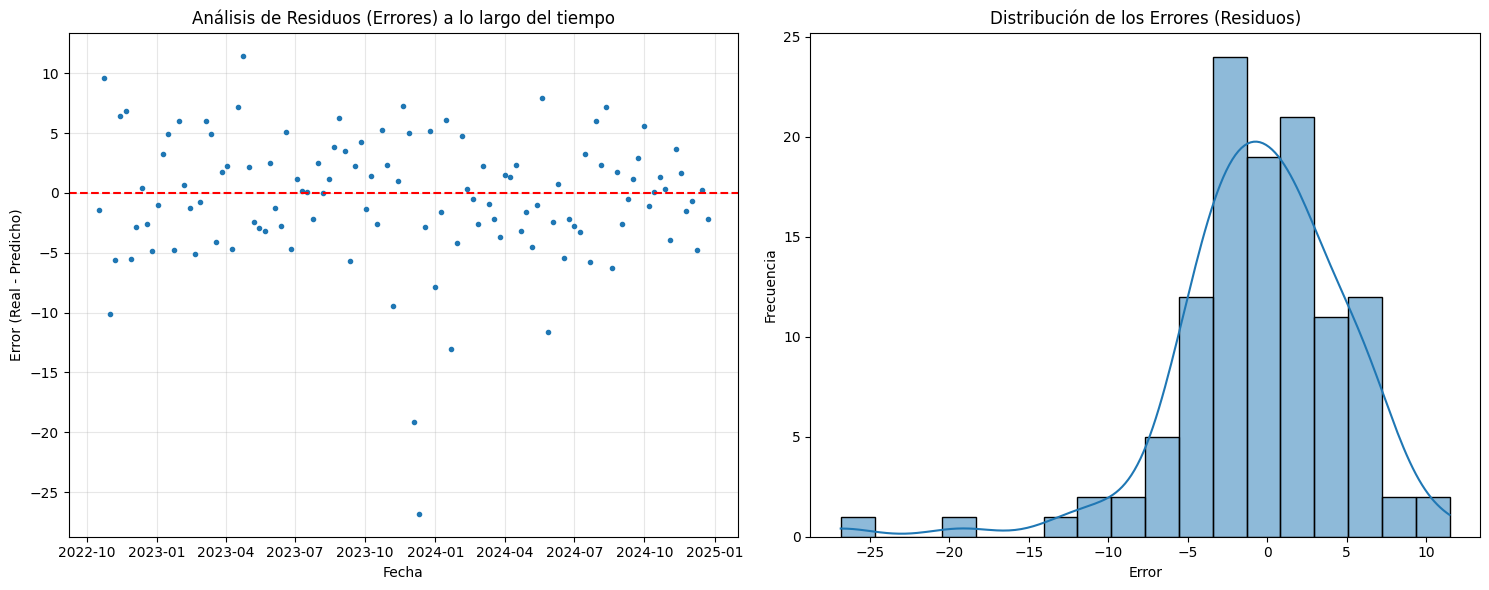

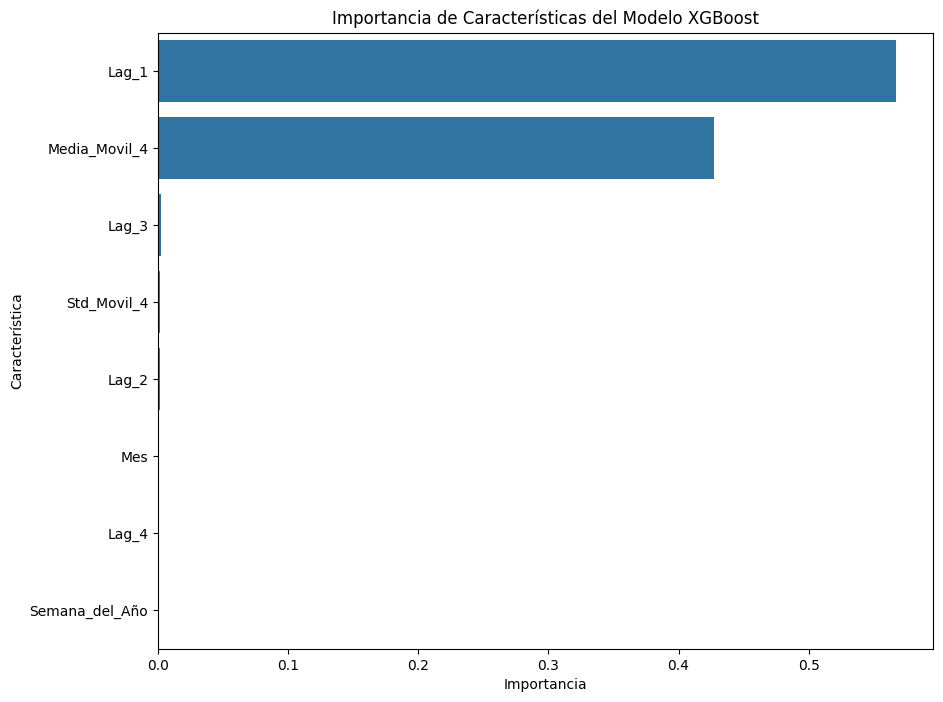

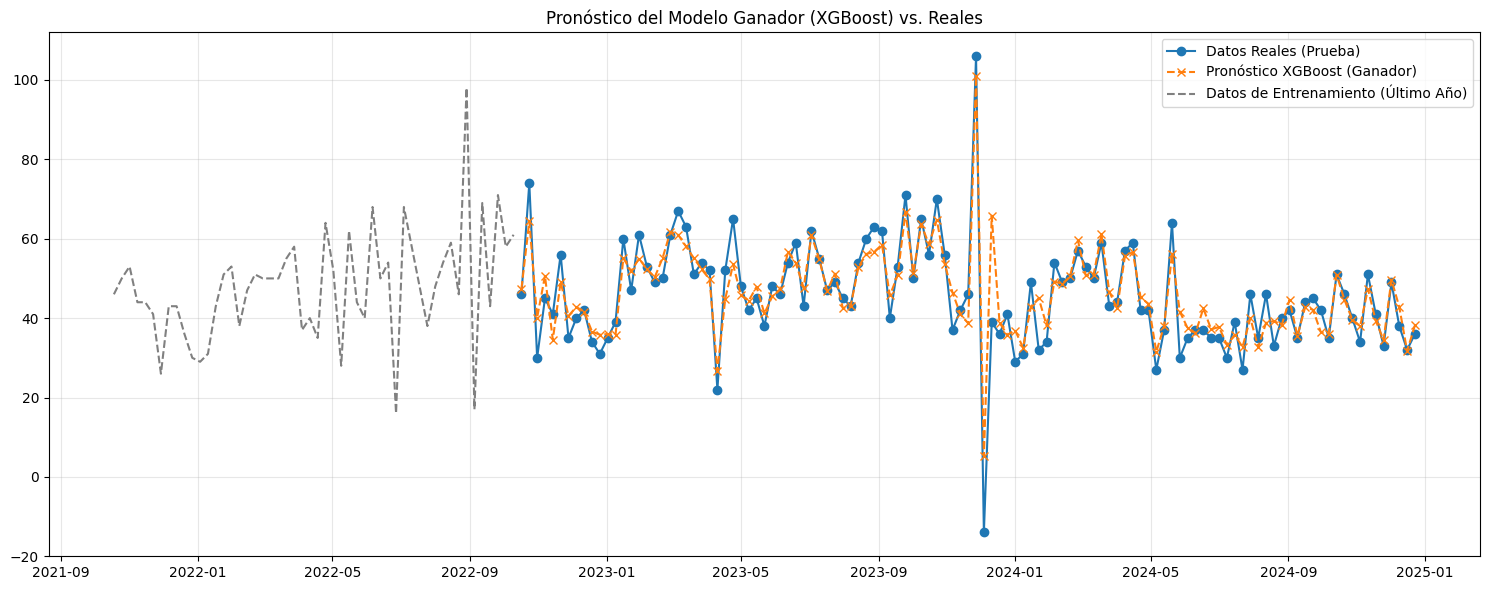

--- Fin del Análisis ---


In [130]:
# --- ANÁLISIS DEL MODELO GANADOR (XGBoost) ---

print(f"\n--- Iniciando Paso 7: Análisis del Modelo Ganador ({modelo_ganador_nombre}) ---")

# Se usa el mejor modelo XGBoost que ya estaba entrenado
# best_xgb = grid_search_xgb.best_estimator_ (del Paso 1)
# y_pred_xgb (del Paso 1)

# --- Análisis de Residuos ---
# Los residuos son la diferencia entre los valores reales y los predichos.
residuos_xgb = y_test - y_pred_xgb

plt.figure(figsize=(15, 6))

# Gráfico de Residuos a lo largo del tiempo
plt.subplot(1, 2, 1)
plt.plot(test_fe.index, residuos_xgb, marker='.', linestyle='None')
plt.axhline(0, color='red', linestyle='--')
plt.title('Análisis de Residuos (Errores) a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Error (Real - Predicho)')
plt.grid(True, alpha=0.3)

# Histograma de Residuos
plt.subplot(1, 2, 2)
sns.histplot(residuos_xgb, kde=True)
plt.title('Distribución de los Errores (Residuos)')
plt.xlabel('Error')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# --- Gráfico de Importancia de Características ---
# Este gráfico nos dice qué variables consideró más importantes el XGBoost.
plt.figure(figsize=(10, 8))
# Se obtienen las importancias
importancias = final_xgb_model.feature_importances_
# Se crea un DataFrame para graficar
feature_names = X_train.columns
importancia_df = pd.DataFrame({'Característica': feature_names, 'Importancia': importancias})
importancia_df.sort_values(by='Importancia', ascending=False, inplace=True)

# Se grafica
sns.barplot(x='Importancia', y='Característica', data=importancia_df)
plt.title('Importancia de Características del Modelo XGBoost')
plt.show()


# --- Gráfico de Tendencia y Predicción ---
# (Este es el gráfico de evaluación que ya habíamos planeado)
plt.figure(figsize=(15, 6))
plt.plot(test_fe.index, y_test, 'o-', label='Datos Reales (Prueba)')
plt.plot(test_fe.index, y_pred_xgb, 'x--', label='Pronóstico XGBoost (Ganador)')
plt.plot(train_fe.index[-52:], train_fe['total_cases'][-52:], label='Datos de Entrenamiento (Último Año)', color='gray', linestyle='--')
plt.title(f'Pronóstico del Modelo Ganador ({modelo_ganador_nombre}) vs. Reales')
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

print("--- Fin del Análisis ---")

### Conclusiones

Tras la implementación y evaluación de los modelos individuales (Prophet, SARIMAX) y los ensambles (XGBoost como homogéneo y Stacking como heterogéneo), la tabla comparativa de resultados nos ofrece una visión del rendimiento de cada enfoque.

Observaciones Clave

    Dominancia de XGBoost: El modelo XGBoost se percibe como el más adecuado en términos de precisión (MAPE de 9.90%) y eficiencia computacional (entrenamiento en 0.19 segundos). Este rendimiento superior se atribuye en gran medida al impacto significativo de las características de ingeniería, especialmente la variables de retraso (lags) y las ventanas móviles. El análisis de importancia de características confirma que Lag_1_semana es, con diferencia, el predictor más influyente.

    Implicación Práctica de la Dependencia del Lag 1: Si bien la alta importancia del lag más reciente impulsa la precisión, también introduce una dependencia operativa. El rendimiento del modelo XGBoost está fuertemente ligado a la disponibilidad inmediata del dato de la semana anterior. Esto es una consideración importante para el IMSS, ya que cualquier retraso en el reporte o consolidación de los datos semanales podría impactar la capacidad de generar un pronóstico oportuno con este modelo.

    Stacking No Supera al Mejor Individual: El ensamble heterogéneo (Stacking), con un MAPE de 19.83%, no logró mejorar la precisión de XGBoost. Este resultado sugiere que la combinación de modelos con rendimientos tan dispares no aportó valor adicional, posiblemente porque la fuerte señal de XGBoost fue diluida por el ruido de los modelos menos precisos.

    Limitaciones de los Modelos de Series de Tiempo Puros: Prophet (MAPE 30.57%) y SARIMAX (MAPE 53.24%) mostraron un rendimiento inferior y, en el caso de SARIMAX, un costo computacional significativamente mayor. Esto refuerza la idea de que, para esta serie temporal agregada, un enfoque basado en características explícitas fue más efectivo.


Selección del Modelo y Consideraciones Futuras

Basado en la evidencia experimental (mayor precisión y eficiencia), se selecciona el modelo XGBoost como el modelo final para esta etapa. Sin embargo, se reconoce la dependencia operativa mencionada respecto al Lag_1. Para mitigar este riesgo en una implementación futura, se podrían explorar dos estrategias:

    Ingeniería de Características Alternativa: Investigar si modelos basados en lags más antiguos (Lag_2, Lag_3, etc.) o en características menos dependientes del tiempo inmediato (como promedios móviles más largos) pueden ofrecer un balance aceptable entre precisión y robustez ante retrasos.

    Evaluación del Impacto del Retraso: Simular escenarios donde el dato de Lag_1 no esté disponible y evaluar cuánto se degrada la precisión del modelo XGBoost. Esto ayudaría al IMSS a entender el riesgo real.

Como exploración adicional, también se podría considerar un ensamble Stacking más selectivo (XGBoost + Prophet). No obstante, por ahora, XGBoost se mantiene como la solución más adecuada, con la advertencia sobre su dependencia del dato más reciente.